In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)



x = torch.LongTensor(x_)
y = torch.LongTensor(y_)


hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [68]:

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.RNN(hidden_size, hidden_size)
        self.decoder = nn.RNN(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()
    
    
    

In [69]:
seq2seq = Seq2Seq(vocab_size, 16)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)


In [70]:

log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n Epoch:%d Loss: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])
        
        
        
        



 Epoch:0 Loss: 5.487034797668457
['Ì', 'Ì', 'Ì', 'h']

 Epoch:100 Loss: 2.2085561752319336
['h', 'o', 'l', 'a']

 Epoch:200 Loss: 0.5697696805000305
['h', 'o', 'l', 'a']

 Epoch:300 Loss: 0.23419272899627686
['h', 'o', 'l', 'a']

 Epoch:400 Loss: 0.13768835365772247
['h', 'o', 'l', 'a']

 Epoch:500 Loss: 0.0942625030875206
['h', 'o', 'l', 'a']

 Epoch:600 Loss: 0.06995206326246262
['h', 'o', 'l', 'a']

 Epoch:700 Loss: 0.05457751452922821
['h', 'o', 'l', 'a']

 Epoch:800 Loss: 0.04406547546386719
['h', 'o', 'l', 'a']

 Epoch:900 Loss: 0.036478057503700256
['h', 'o', 'l', 'a']


In [71]:

class Seq2Seq_GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq_GRU, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()
    
    
    

In [72]:
seq2seq = Seq2Seq_GRU(vocab_size, 16)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)


In [73]:

log_1 = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log_1.append(loss_val)
    if i % 100 == 0:
        print("\n Epoch:%d Loss: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])
        
        
        
        



 Epoch:0 Loss: 5.523732662200928
['\\', 'V', 'Ñ', '\x9d']

 Epoch:100 Loss: 1.7482703924179077
['h', 'o', 'l', 'h']

 Epoch:200 Loss: 0.5666818618774414
['h', 'o', 'l', 'a']

 Epoch:300 Loss: 0.2939830720424652
['h', 'o', 'l', 'a']

 Epoch:400 Loss: 0.1735731065273285
['h', 'o', 'l', 'a']

 Epoch:500 Loss: 0.11890894174575806
['h', 'o', 'l', 'a']

 Epoch:600 Loss: 0.08846402913331985
['h', 'o', 'l', 'a']

 Epoch:700 Loss: 0.06885991245508194
['h', 'o', 'l', 'a']

 Epoch:800 Loss: 0.05474279448390007
['h', 'o', 'l', 'a']

 Epoch:900 Loss: 0.04402141273021698
['h', 'o', 'l', 'a']


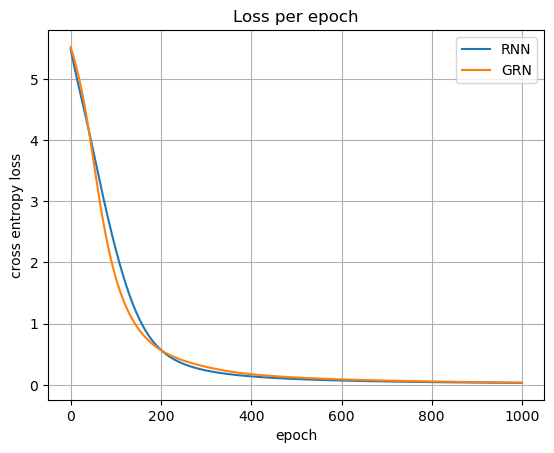

In [75]:
plt.plot(log, label = 'RNN')
plt.plot(log_1,label = 'GRN')
plt.ylabel('cross entropy loss')
plt.xlabel('epoch')
plt.title("Loss per epoch")
plt.grid()
plt.legend()
plt.show()